# Denormalized Cluster Analysis

In [1]:
import collections
import os
import re
import json

import numpy as np
import pandas as pd
import nltk
import sklearn.cross_validation as skcv
import sklearn.decomposition as skd
import sklearn.ensemble as skens
import sklearn.feature_extraction.text as skft
import sklearn.naive_bayes as sknb
import sklearn.pipeline as skpipe
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import sklearn.preprocessing as skp
from ast import literal_eval
from nltk.util import ngrams
from sklearn import metrics
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pandas.tools.plotting import radviz
from pandas.tools.plotting import bootstrap_plot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import parallel_coordinates
from pandas.tools.plotting import andrews_curves

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', color_codes=True, font_scale=1.3)
sns.set(style='white', color_codes=True, font_scale=1.3)

### Load Dataframe

In [2]:
df = pd.DataFrame.from_csv('cluster.csv', index_col=0)

In [40]:
df = df.rename(columns=lambda x: x.strip())

In [41]:
df.shape
df.payment_type.unique()

array(['CSH', 'DIS', 'NOC', 'CRD', 'UNK'], dtype=object)

### Copy original dataframe and binarize vendor id and payment method

In [42]:
dfclean = df.copy()

In [43]:
dfclean["CMT"] = 0
dfclean["VTS"] = 0
dfclean["CSH"] = 0
dfclean["DIS"] = 0
dfclean["NOC"] = 0
dfclean["CRD"] = 0
dfclean["UNKNOWN"] = 0


dfclean.loc[dfclean['vendor_id'] == 'CMT','CMT'] = 1
dfclean.loc[dfclean['vendor_id'] == 'VTS','VTS'] = 1
dfclean.loc[dfclean['payment_type'] == 'CSH','CSH'] = 1
dfclean.loc[dfclean['payment_type'] == 'DIS','DIS'] = 1
dfclean.loc[dfclean['payment_type'] == 'NOC','NOC'] = 1
dfclean.loc[dfclean['payment_type'] == 'CRD','CRD'] = 1
dfclean.loc[dfclean['payment_type'] == 'UNKNOWN','UNKNOWN'] = 1

dfclean.head()

,hack_license,vendor_id,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD,UNKNOWN
medallion,,,,,,,,,,,,,,,,,,,,
89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,CSH,6.5,0.0,0.5,0,0,7.0,1,4,382,1.0,1,0,1,0,0,0,0
0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,CSH,6.0,0.5,0.5,0,0,7.0,1,1,259,1.5,1,0,1,0,0,0,0
0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,CSH,5.5,1.0,0.5,0,0,7.0,1,1,282,1.1,1,0,1,0,0,0,0
DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,CSH,5.0,0.5,0.5,0,0,6.0,1,2,244,0.7,1,0,1,0,0,0,0
DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,CSH,9.5,0.5,0.5,0,0,10.5,1,1,560,2.1,1,0,1,0,0,0,0


#### In the cell below I was considering nominalizing the categories and keeping them in their respective columns, but decided it would be better to list them in their own binary columns.

In [44]:
# dfclean.loc[dfclean['vendor_id'] == "CMT",'vendor_id'] = 0
# dfclean.loc[dfclean['vendor_id'] == "VTS",'vendor_id'] = 1
# dfclean.loc[dfclean['payment_type'] == "CSH",'payment_type'] = 0
# dfclean.loc[dfclean['payment_type'] == "DIS",'payment_type'] = 1
# dfclean.loc[dfclean['payment_type'] == "NOC",'payment_type'] = 2
# dfclean.loc[dfclean['payment_type'] == "CRD",'payment_type'] = 3
# dfclean.loc[dfclean['payment_type'] == "UNKNOWN",'payment_type'] = 4

# dfclean

### Since the dataframe contains thousands of unique cab and license numbers, I removed the column containing hack licenses. I also removed the old vendor id, payment type, and GIS columns.

In [46]:
# dfclean = dfclean.drop(dfclean.columns[[0,1,2,-1]], axis=1)
dfclean.head()

,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD
medallion,,,,,,,,,,,,,,,,
89D227B655E5C82AECF13C3F540D4CF4,6.5,0.0,0.5,0,0,7.0,1,4,382,1.0,1,0,1,0,0,0
0BD7C8F5BA12B88E0B67BED28BEA73D8,6.0,0.5,0.5,0,0,7.0,1,1,259,1.5,1,0,1,0,0,0
0BD7C8F5BA12B88E0B67BED28BEA73D8,5.5,1.0,0.5,0,0,7.0,1,1,282,1.1,1,0,1,0,0,0
DFD2202EE08F7A8DC9A57B02ACB81FE2,5.0,0.5,0.5,0,0,6.0,1,2,244,0.7,1,0,1,0,0,0
DFD2202EE08F7A8DC9A57B02ACB81FE2,9.5,0.5,0.5,0,0,10.5,1,1,560,2.1,1,0,1,0,0,0


### In order to work within my computers memory and computing power, I sampled 4000 rows to use for cluster analysis. The data was then normalized and all payment methods except for card and cash were dropped.

In [47]:
dfsample = dfclean.sample(n=4000)
dfsample.shape
dfsample.head()

,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD
medallion,,,,,,,,,,,,,,,,
323CFA8722F8D8E1CC90FF3C6FE3964B,8.5,0.0,0.5,0.00,0,9.00,1,1,600,1.48,0,1,1,0,0,0
C32B06F65E2D8246687B73D096833A93,13.0,0.5,0.5,0.00,0,14.00,1,2,960,2.63,0,1,1,0,0,0
F345E6D7963DE6E5A5F7ED24869DDB6A,5.5,0.5,0.5,0.00,0,6.50,1,1,300,0.82,0,1,1,0,0,0
84AE9838EE99784329E816771F88C97B,18.5,1.0,0.5,4.88,0,24.88,1,1,1440,4.23,0,1,0,0,0,1
9364D7B4997CF34F9FA76664DD20E0EE,7.0,0.0,0.5,0.00,0,7.50,1,1,360,1.69,0,1,1,0,0,0


In [48]:
dfnorm = dfsample.apply(lambda x: (x-x.mean())/x.std())
dfnorm = dfnorm.drop(dfnorm.columns[[-2,-3]], axis=1)
dfnorm.head()

,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,CRD
medallion,,,,,,,,,,,,,,
323CFA8722F8D8E1CC90FF3C6FE3964B,-0.360292,-0.819838,0.069076,-0.632015,-0.195287,-0.455441,-0.12795,-0.657396,-0.195561,-0.427814,-0.061345,0.061345,1.071958,-1.070344
C32B06F65E2D8246687B73D096833A93,0.098361,0.529690,0.069076,-0.632015,-0.195287,-0.032294,-0.12795,-0.083376,0.538645,-0.083177,-0.061345,0.061345,1.071958,-1.070344
F345E6D7963DE6E5A5F7ED24869DDB6A,-0.666060,0.529690,0.069076,-0.632015,-0.195287,-0.667015,-0.12795,-0.657396,-0.807399,-0.625606,-0.061345,0.061345,1.071958,-1.070344
84AE9838EE99784329E816771F88C97B,0.658935,1.879217,0.069076,1.688920,-0.195287,0.888476,-0.12795,-0.657396,1.517585,0.396318,-0.061345,0.061345,-0.932639,0.934046
9364D7B4997CF34F9FA76664DD20E0EE,-0.513176,-0.819838,0.069076,-0.632015,-0.195287,-0.582385,-0.12795,-0.657396,-0.685031,-0.364881,-0.061345,0.061345,1.071958,-1.070344


### First step to calculating dendrogram and k-means is to determine distance metric and linkage method. 
>I chose Hamming distance (https://en.wikipedia.org/wiki/Hamming_distance) because it seemed to provide the best results and I wanted to toy around with different type of distance metrics. Euclidian and cosine methods didn't yield results that were as nice as those provided by Hamming distance.

In [49]:
#STEP 1
# https://en.wikipedia.org/wiki/Hamming_distance

dist = spd.squareform(spd.pdist(dfnorm, metric='hamming'))
dist.shape

(4000, 4000)

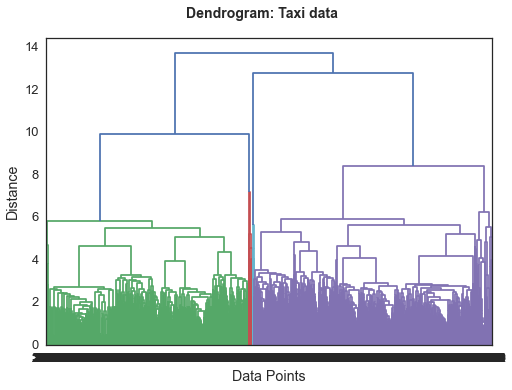

In [50]:
linkz = sph.linkage(dist, method='weighted')  # obtain the linkage matrix
plotz = sph.dendrogram(linkz)  # plot the linkage matrix as a dendrogram
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: Taxi data', 
             fontweight='bold', fontsize=14);

### From the dendrogram and cluster labels that were appended to the denormalized sample dataframe, we can see that their are two main groups, green and purple, and two smaller groups, red and blue.
>Based on the dendrogram result, silhouette scores, and elbow plots, I decided to cut the cluster labels at 9 because that provides a manageable group of clusters. If I cut it lower than 9, I would likely end up with 6 or more clusters and that made it difficult to display visuals and interpret groupings.

In [53]:
clusterlabels = sph.fcluster(linkz, 9, criterion='distance')
dfsample['Cluster Label'] = clusterlabels

# dfsample = dfsample.drop(dfsample.columns[[-3,-4]], axis=1)
dfsample.head()

C:\Users\Joer\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD,Cluster Label
medallion,,,,,,,,,,,,,,,,,
323CFA8722F8D8E1CC90FF3C6FE3964B,8.5,0.0,0.5,0.00,0,9.00,1,1,600,1.48,0,1,1,0,0,0,1
C32B06F65E2D8246687B73D096833A93,13.0,0.5,0.5,0.00,0,14.00,1,2,960,2.63,0,1,1,0,0,0,1
F345E6D7963DE6E5A5F7ED24869DDB6A,5.5,0.5,0.5,0.00,0,6.50,1,1,300,0.82,0,1,1,0,0,0,1
84AE9838EE99784329E816771F88C97B,18.5,1.0,0.5,4.88,0,24.88,1,1,1440,4.23,0,1,0,0,0,1,4
9364D7B4997CF34F9FA76664DD20E0EE,7.0,0.0,0.5,0.00,0,7.50,1,1,360,1.69,0,1,1,0,0,0,1


In [91]:
#k = 2 gives the highest silhouette score, but again, that leaves us with too many categories (or at least more than
#I was interested in working with)

In [52]:
#k = 2 gives highest silhouette score
for k in range(2,10):
    kmeans_model = skc.KMeans(n_clusters=k, random_state=0).fit(dfsample)
    score = skm.silhouette_score(dfsample, kmeans_model.labels_)
    print('k = %d, silhouette_score = %f'%(k, score))

k = 2, silhouette_score = 0.646298
k = 3, silhouette_score = 0.580745
k = 4, silhouette_score = 0.571282
k = 5, silhouette_score = 0.552741
k = 6, silhouette_score = 0.555231
k = 7, silhouette_score = 0.551271
k = 8, silhouette_score = 0.557432
k = 9, silhouette_score = 0.570851


### Elbow and bayesian scores run the sample dataframe through k-means iterations and help determine the amount of clusters that are optimal
>For my purposes, I chose 9 clusters as the ideal k means input.

>The elbow and bayesian plots select dfsample from columns zero to -1 so as not to include the actual category labels in the analysis.

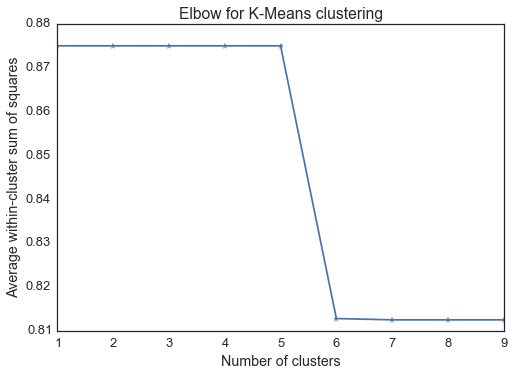

In [54]:
X = dfsample.ix[:,:-1]  # Using the the dataset of Section 1
K = range(1,10)  
kmeans_models = [skc.KMeans(k).fit(X) for k in K]
centroids = [m.cluster_centers_ for m in kmeans_models]
D_k = [spd.cdist(X, cent, 'hamming') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

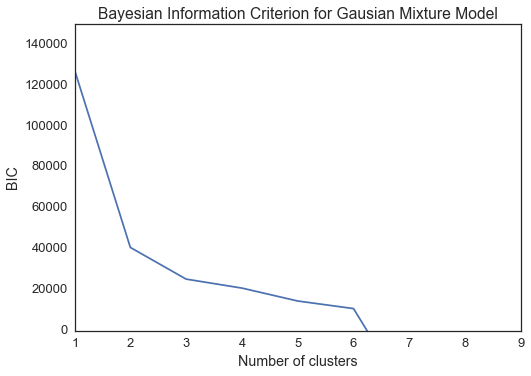

In [55]:
X = dfsample.ix[:,:-1]  # Using the the dataset of Section 1
K = range(1,10)  # Apply kmeans 1 to 10
gmms = [skmix.GMM(k).fit(X) for k in K]
bics = [g.bic(X) for g in gmms]
plt.plot(K, bics)
kIdx = np.argmin(bics)  # <-- the selected index
plt.plot(K[kIdx], bics[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.ylim(0,plt.ylim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.title('Bayesian Information Criterion for Gausian Mixture Model')

### Perform PCA dimensionality reduction and k-means models for n components = 4 through n components = 9. Distinct groups can be seen in the plots.
>The number of components determines the amount of centroids used to calculate the k-means. Since the centroids are randomly generated, the graphs can change each time the cell is executed.

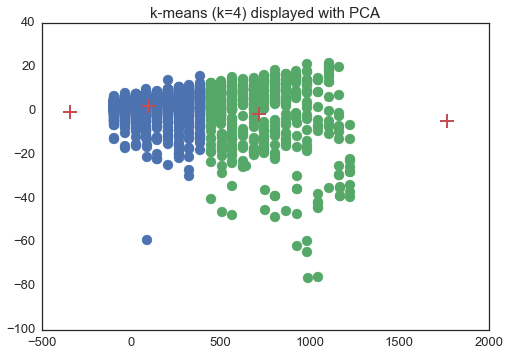

In [56]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=4)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(4).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=4) displayed with PCA', fontsize=15);

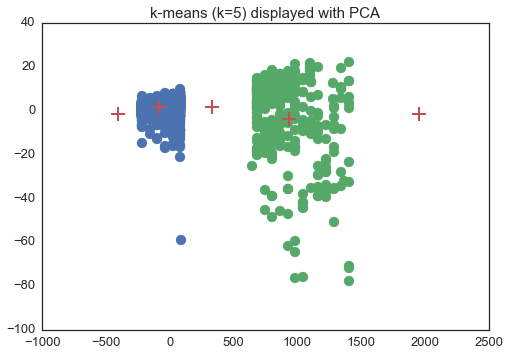

In [57]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=5)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(5).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=5) displayed with PCA', fontsize=15);

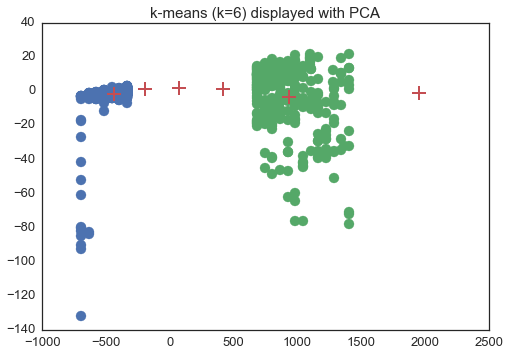

In [58]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=6)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(6).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=6) displayed with PCA', fontsize=15);

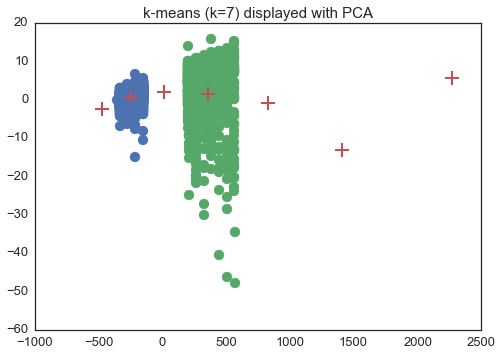

In [59]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=7)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(7).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=7) displayed with PCA', fontsize=15);

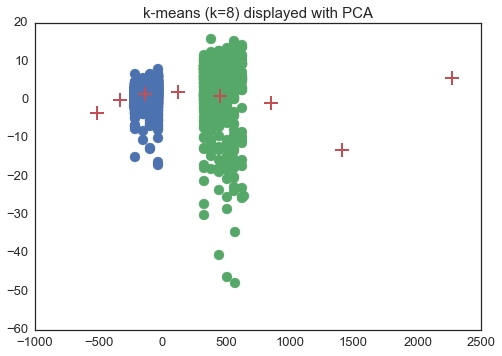

In [60]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=8)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(8).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=8) displayed with PCA', fontsize=15);

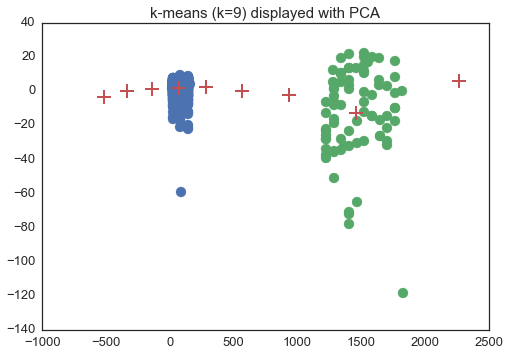

In [61]:
# PCA for dimensionality reduction
pca = skd.PCA(n_components=9)
traits_pca = pca.fit_transform(dfsample)

# K-means
kmeans_model = skc.KMeans(9).fit(dfsample)
centroids = kmeans_model.cluster_centers_
centroids_pca = pca.transform(centroids)
cluster_labels = kmeans_model.labels_

# Plot the results on 2-D scatterplot with cluster centroids
plt.scatter(traits_pca[cluster_labels==0,0], 
            traits_pca[cluster_labels==0,1],
            s=100, color='b')
plt.scatter(traits_pca[cluster_labels==1,0], 
            traits_pca[cluster_labels==1,1],
            s=100, color='g')
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], marker='+', s=200,
            linewidths=2, color='r')
plt.title('k-means (k=9) displayed with PCA', fontsize=15);

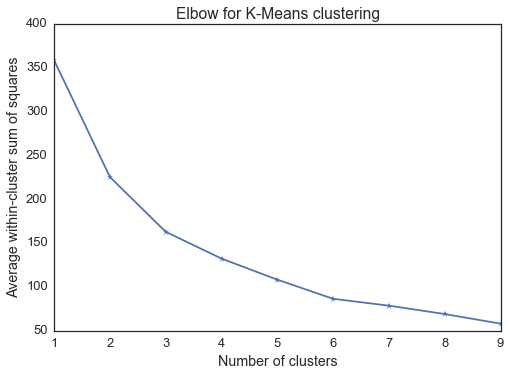

In [62]:
X = dfsample.ix[:,:-1]  # Using the the dataset of Section 1
K = range(1,10)  # Apply kmeans 1 to 10
kmeans_models = [skc.KMeans(k).fit(X) for k in K]
centroids = [m.cluster_centers_ for m in kmeans_models]
D_k = [spd.cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

### The rest of the visualizations in this notebook are meant to explore the different clusters and unearth the features and characteristics that make those taxi ride types distinct from other rides.

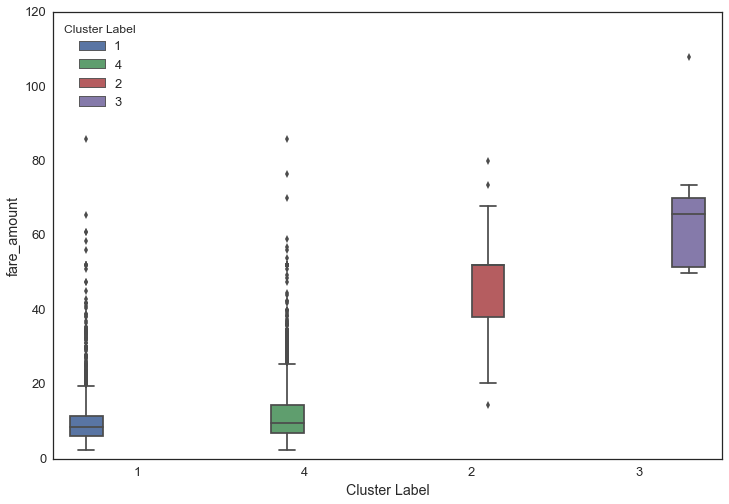

In [88]:
plt.figure(figsize=(12,8));
yo = sns.boxplot(x='Cluster Label', y='fare_amount', data=dfsample, 
            hue='Cluster Label');

yo

fig = yo.get_figure()
fig.savefig("farecluster.png")

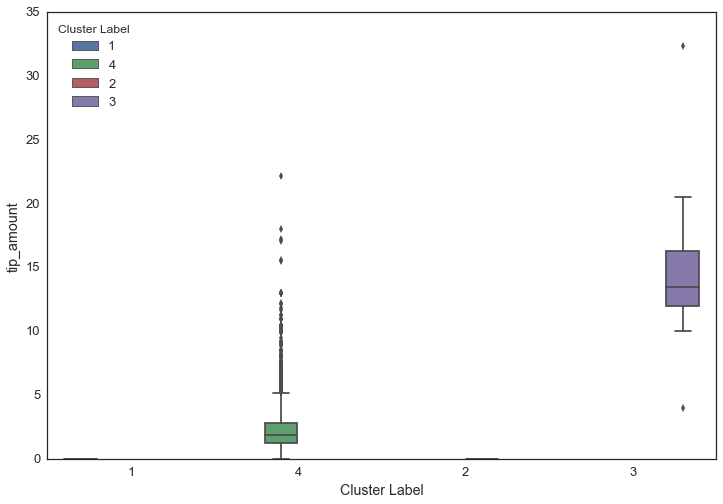

In [90]:
plt.figure(figsize=(12,8));
yolo = sns.boxplot(x='Cluster Label', y='tip_amount', data=dfsample, 
            hue='Cluster Label');

fig = yolo.get_figure()
fig.savefig("tipcluster.png")

### FINDINGS from prior two boxplots: 

Cluster 3 trips have higher fares and passengers tip more. They also tip more consistently within the boxplot quartiles. Cluster 4 has lower fare amounts and lower tip amounts, but there are a lot more tip variance and outliers present. Based on previous correlations, I would guess cluster 3 is a long trip, and cluster 4 is a short trip. Clusters 1 and 2 share similar qualities regarding trip fare and length, but those passengers often provide no tip. However, from the dendrogram we can see that clusters 3 and 4 are the main types of taxi trips, with the no-tip clusters 1 and 2 being a smaller fraction of the overall rides.

In [93]:
#The following scatterplot shows that single passengers tip more, and that cluster 3 provides the highest tips,
#followed by cluster 4.

#It appears that there may be a few outliers. I would include outlier analysis for future studies of this data.

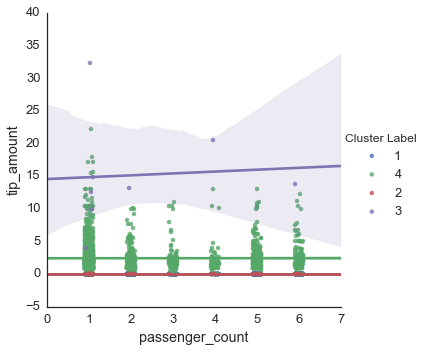

In [65]:
sns.lmplot(x='passenger_count', y='tip_amount', hue='Cluster Label', 
           data=dfsample, fit_reg=True, x_jitter=.1);

### The pairplot reveals important feature correlations with cluster labels
>We can see that fare amount and tip amount are highly correlated with cluster labels.

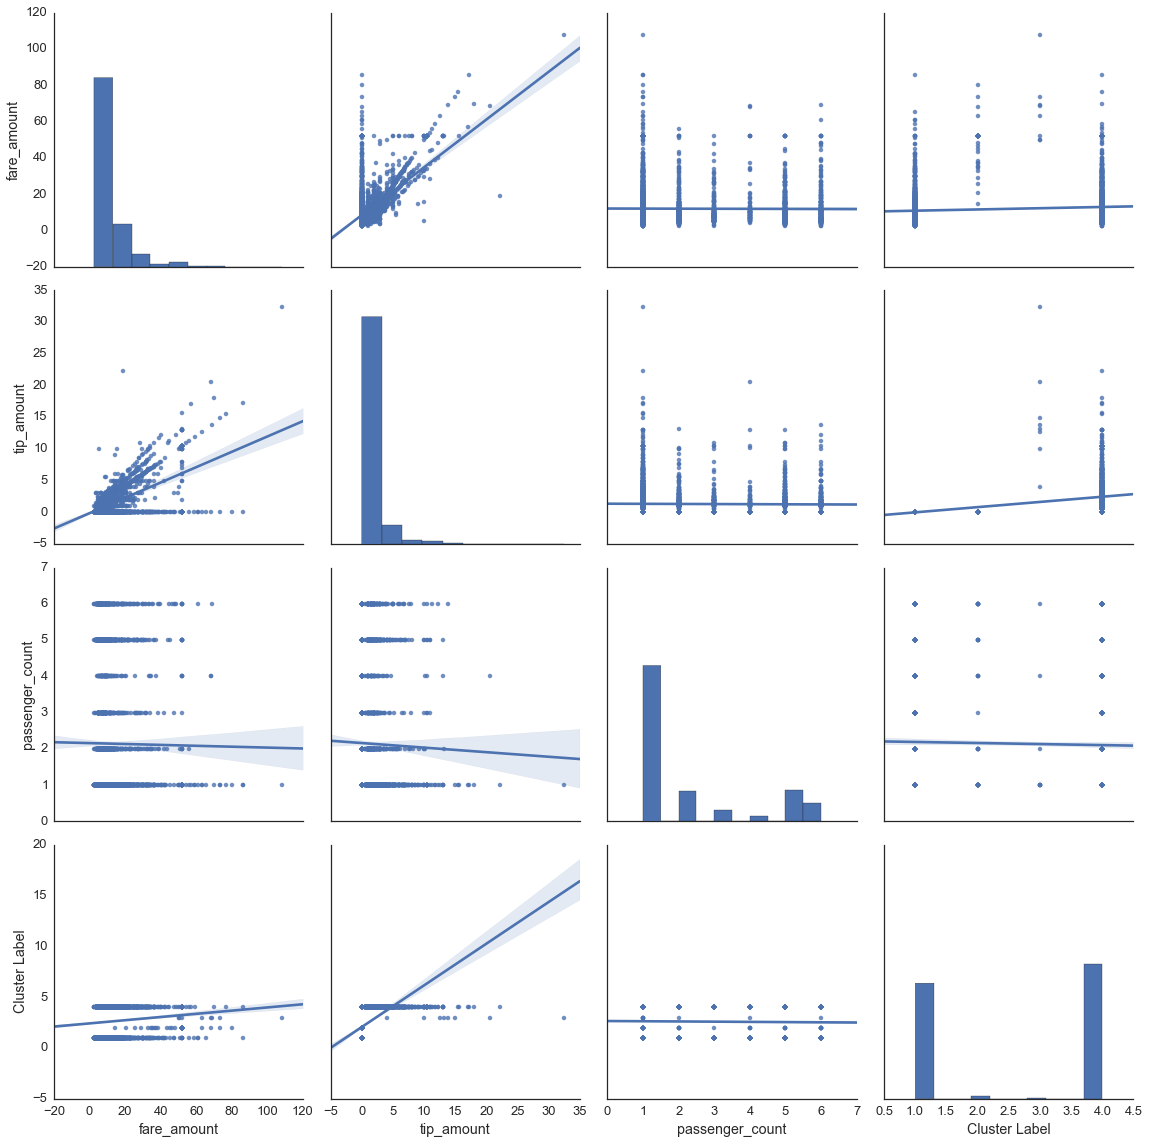

In [66]:
sns.pairplot(dfsample, size = 4, kind="reg", vars=['fare_amount','tip_amount','passenger_count','Cluster Label'])

### To explore the clusters more in-depth, I group on cluster label and take the mean values for each cluster.

In [67]:
cluster = dfsample.groupby(dfsample['Cluster Label']).mean()
cluster

,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,rate_code,passenger_count,trip_time_in_secs,trip_distance,CMT,VTS,CSH,DIS,NOC,CRD
Cluster Label,,,,,,,,,,,,,,,,
1,10.326744,0.292422,0.500000,0.000000,0.047446,11.166612,1.007688,2.179572,620.724876,2.401834,0.00000,1.00000,1,0,0,0.000000
2,47.500000,0.075000,0.437500,0.000000,4.472500,52.485000,1.875000,3.000000,1947.000000,14.977250,0.00000,1.00000,1,0,0,0.000000
3,66.750000,0.125000,0.062500,15.165000,10.187500,92.290000,3.625000,2.125000,1683.000000,14.917500,0.12500,0.87500,0,0,0,0.875000
4,12.623557,0.318395,0.498358,2.437438,0.243430,16.121178,1.039418,2.099953,732.928203,3.068057,0.00657,0.99343,0,0,0,0.999061


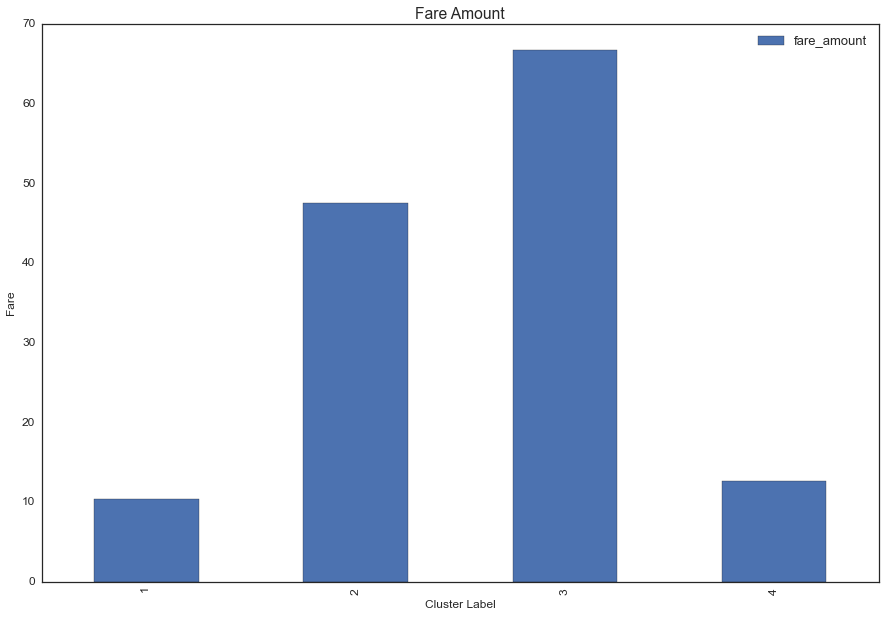

In [68]:
ax = cluster[['fare_amount']].plot(kind='bar', title ="Fare Amount",figsize=(15,10),
                legend=True, fontsize=12)
ax.set_xlabel("Cluster Label",fontsize=12)
ax.set_ylabel("Fare",fontsize=12)
plt.show()

### The following bar chart is expressive and effective for comparing trip type characteristics because we can see that cluster 3 has high fares, low passenger counts, and high tip rates. Cluster 4 has low fare amounts, low passenger counts, and lower tip rates. Clusters 1 and 2 seem to be very similar to clusters 4 and 3, respectively. The only difference is that these groups have slightly lower fares, tend to leave no tip, and may have higher passenger counts.

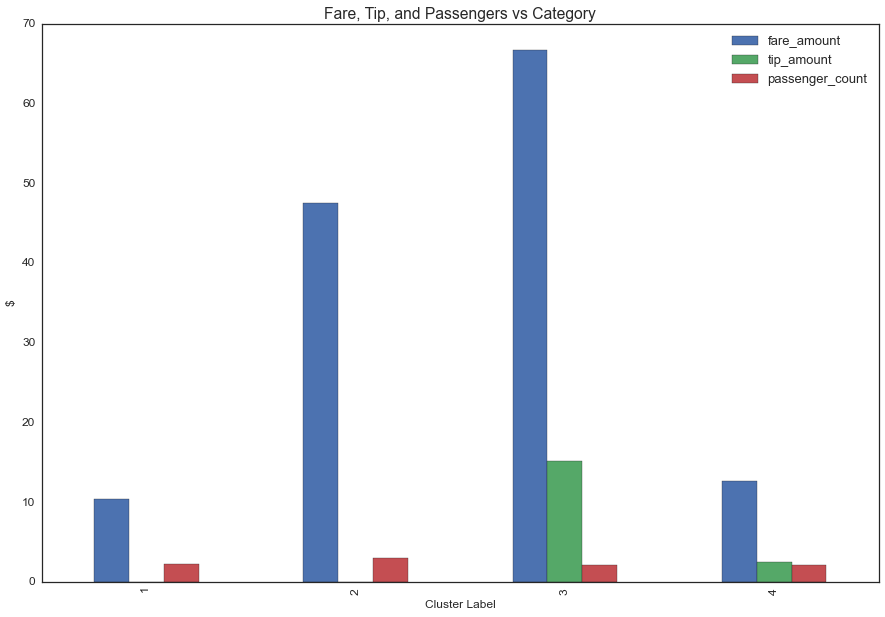

In [79]:
ax = cluster[['fare_amount','tip_amount','passenger_count']].plot(kind='bar', title ="Fare, Tip, and Passengers vs Category",
            figsize=(15,10),legend=True, fontsize=12)
ax.set_xlabel("Cluster Label",fontsize=12)
ax.set_ylabel("$",fontsize=12)
plt.show()

fig = ax.get_figure()
fig.savefig("bar.png")

### As seen in the bar chart below, trip distances correlate and move in tandem with fare amounts. Although it's interesting to note that despite leaving no tip, having a lower fare amount, and having a higher passenger count, cluster two trips travel the same mean distance as group 3. This could mean that trips in category 2 are rides with 2 or more people at a reduced fare rate. And for some reason they don't tip. This should be a point for further future analysis.

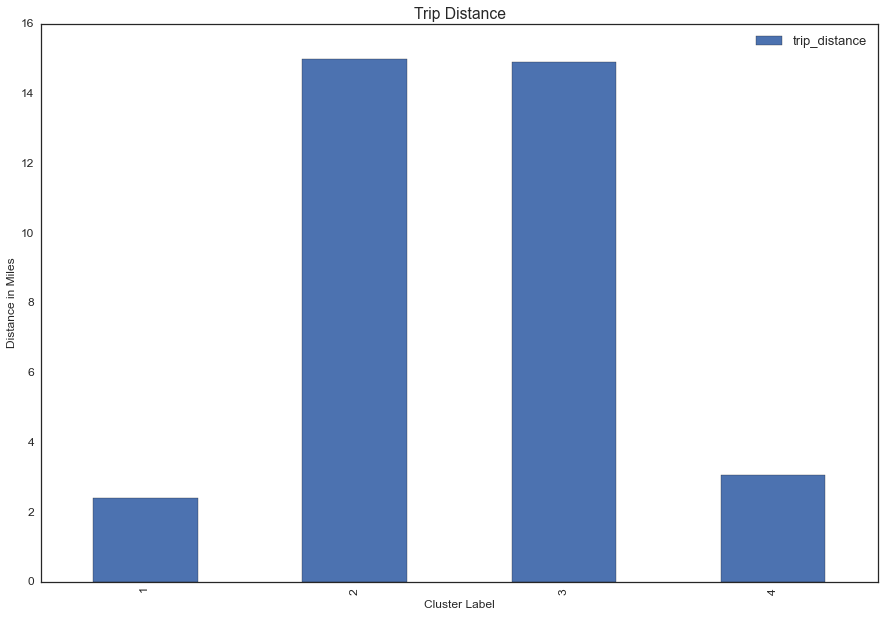

In [80]:
ax = cluster[['trip_distance']].plot(kind='bar', title ="Trip Distance",figsize=(15,10),
                legend=True, fontsize=12)
ax.set_xlabel("Cluster Label",fontsize=12)
ax.set_ylabel("Distance in Miles",fontsize=12)
plt.show()

### I'm not sure if this is simply a result of the way I computed cluster labels, but the model seems to have heavily factored payment method into it's grouping decisions. Clusters 1 and 2 pay with cash and clusters 3 and 4 tend to pay with card.

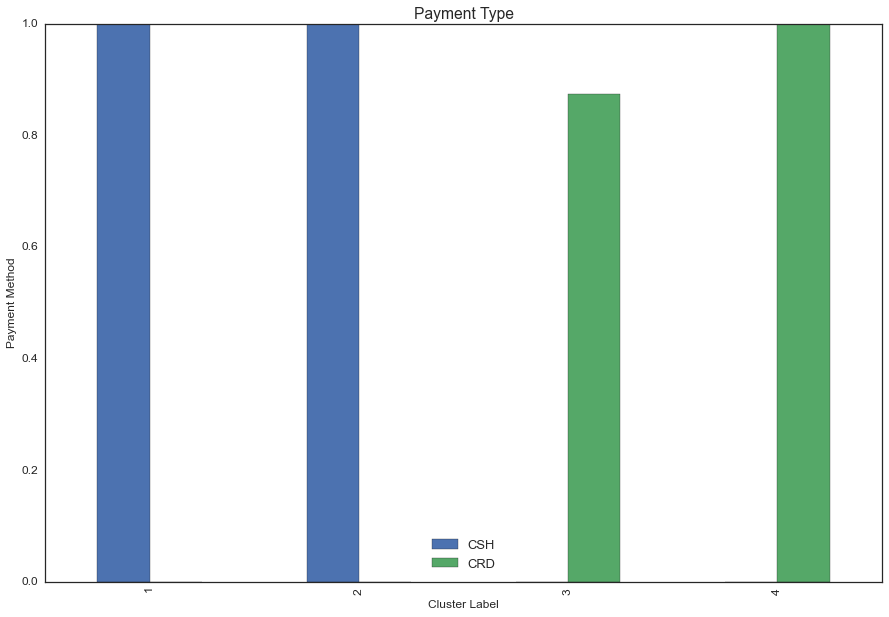

In [81]:
ax = cluster[['CSH','CRD']].plot(kind='bar', title ="Payment Type",figsize=(15,10),
                legend=True, fontsize=12)
ax.set_xlabel("Cluster Label",fontsize=12)
ax.set_ylabel("Payment Method",fontsize=12)
plt.show()

### Out of curiousity, I also ran a PCA model to create a biplot. The only information I was able to glean from the PCA plot at the bottom was that total amount and fare amount are the most important or distinguishing features in the model.

In [82]:
# Create a PCA model
pca_model = skd.PCA().fit(dfsample.ix[:,:-1])

pca_model.components_.shape

(16, 16)

In [83]:
# Look at the variances explained by each component.
# These values equal to the eigenvalues of the correlation matrix.
pca_model.explained_variance_

array([  2.40522051e+05,   8.36400266e+01,   4.32248440e+00,
         3.03591767e+00,   1.42859794e+00,   8.78902780e-01,
         2.56890864e-01,   1.69514664e-01,   3.60873653e-02,
         7.42223567e-03,   6.44760468e-04,   3.54760130e-04,
         7.28929081e-30,   5.83412147e-34,   5.07377519e-73,
         0.00000000e+00])

In [94]:
#Scree plots are meant to help determine break points/features, much like an Elbow test for k-means

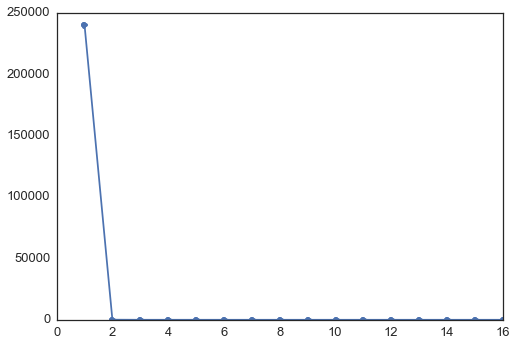

In [84]:
# A "scree" plot.
plt.plot(range(1,17), pca_model.explained_variance_, 'b-o')

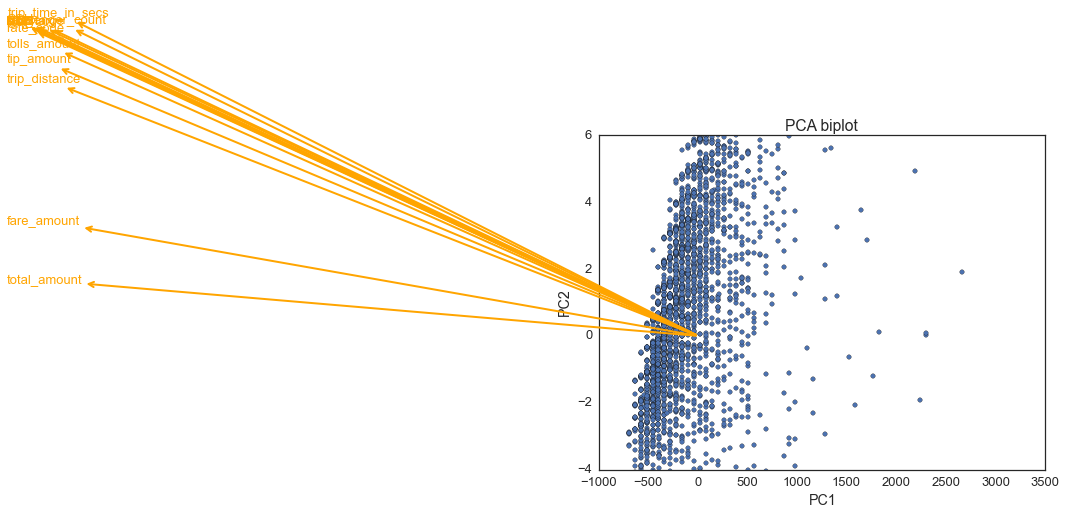

In [85]:
# Scatterplot of disaggregated data
X = pca_model.transform(dfsample.ix[:,:-1])
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot')
plt.ylim(-4, 6)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    plt.annotate(dfsample.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=13, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, color='orange'))